In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
import lightgbm as lgb
from lightgbm import LGBMRegressor

# 1. Data Cleaning

In [31]:
df = pd.read_csv('MTA_Daily_Ridership_Data.csv')
df.head()

,Date,Subways: Total Estimated Ridership,Subways: % of Comparable Pre-Pandemic Day,Buses: Total Estimated Ridership,Buses: % of Comparable Pre-Pandemic Day,LIRR: Total Estimated Ridership,LIRR: % of Comparable Pre-Pandemic Day,Metro-North: Total Estimated Ridership,Metro-North: % of Comparable Pre-Pandemic Day,Access-A-Ride: Total Scheduled Trips,Access-A-Ride: % of Comparable Pre-Pandemic Day,Bridges and Tunnels: Total Traffic,Bridges and Tunnels: % of Comparable Pre-Pandemic Day,Staten Island Railway: Total Estimated Ridership,Staten Island Railway: % of Comparable Pre-Pandemic Day
0,03/01/2020,2212965,0.97,984908,0.99,86790,1.00,55825,0.59,19922,1.13,786960,0.98,1636,0.52
1,03/02/2020,5329915,0.96,2209066,0.99,321569,1.03,180701,0.66,30338,1.02,874619,0.95,17140,1.07
2,03/03/2020,5481103,0.98,2228608,0.99,319727,1.02,190648,0.69,32767,1.10,882175,0.96,17453,1.09
3,03/04/2020,5498809,0.99,2177165,0.97,311662,0.99,192689,0.70,34297,1.15,905558,0.98,17136,1.07
4,03/05/2020,5496453,0.99,2244515,1.00,307597,0.98,194386,0.70,33209,1.12,929298,1.01,17203,1.08


In [32]:
columns = [
    'Subways: Total Estimated Ridership',
    'Buses: Total Estimated Ridership',
    'LIRR: Total Estimated Ridership',
    'Metro-North: Total Estimated Ridership',
    'Staten Island Railway: Total Estimated Ridership',
]

In [33]:
# Filter DataFrame in place to keep only the specified columns plus Date
df = df[['Date'] + columns]
df.head()

,Date,Subways: Total Estimated Ridership,Buses: Total Estimated Ridership,LIRR: Total Estimated Ridership,Metro-North: Total Estimated Ridership,Staten Island Railway: Total Estimated Ridership
0,03/01/2020,2212965,984908,86790,55825,1636
1,03/02/2020,5329915,2209066,321569,180701,17140
2,03/03/2020,5481103,2228608,319727,190648,17453
3,03/04/2020,5498809,2177165,311662,192689,17136
4,03/05/2020,5496453,2244515,307597,194386,17203


In [34]:
df['Date'] = pd.to_datetime(df['Date'], format="%m/%d/%Y")

**Adding Temporal Features**

In [35]:
df['Day of Week'] = df['Date'].dt.dayofweek  # 0=Monday, 6=Sunday
df['Month'] = df['Date'].dt.month
df['Year'] = df['Date'].dt.year
df['Is Weekend'] = df['Day of Week'].isin([5,6]).astype(int)
df.head()

,Date,Subways: Total Estimated Ridership,Buses: Total Estimated Ridership,LIRR: Total Estimated Ridership,Metro-North: Total Estimated Ridership,Staten Island Railway: Total Estimated Ridership,Day of Week,Month,Year,Is Weekend
0,2020-03-01,2212965,984908,86790,55825,1636,6,3,2020,1
1,2020-03-02,5329915,2209066,321569,180701,17140,0,3,2020,0
2,2020-03-03,5481103,2228608,319727,190648,17453,1,3,2020,0
3,2020-03-04,5498809,2177165,311662,192689,17136,2,3,2020,0
4,2020-03-05,5496453,2244515,307597,194386,17203,3,3,2020,0


In [36]:
import holidays

us_holidays = holidays.US()
# Convert datetime index to date objects for proper comparison with holidays
df['Is Holiday'] = [1 if date in us_holidays else 0 for date in df['Date'].dt.date]

**Add External Event Features**: COVID, Hurricanes/Floods, Concerts and Sports events

In [37]:
covid_start = pd.to_datetime('2020-03-15')
covid_end = pd.to_datetime('2020-06-30')
df['COVID'] = ((df['Date'] >= covid_start) & (df['Date'] <= covid_end)).astype(int)


In [38]:
NY_HURRICANE_DATES = pd.Series([
    '2020-07-10',
    '2020-07-11', # Tropical Storm Fay 
    '2020-08-04', # Hurricane Isaias
    '2020-08-31', # Hurricane Laura
    '2020-09-21', # Hurricane Teddy
    '2020-09-22',
    '2021-07-09', # Hurricane Elsa
    '2021-08-18', # Tropical Storm Fred
    '2021-08-22', # Hurricane Henri
    '2021-09-01', # Hurricane Ida
    '2022-10-01', # Hurricane Nicole
    '2022-10-02', # Hurricane Nicole
    '2022-10-03', # Hurricane Nicole
    '2022-10-04', # Hurricane Nicole
    '2023-09-28', # Tropical Storm Ophelia
    '2023-09-29',
    '2020-09-30',
    '2024-08-07', # Hurricane Beryl
    '2024-08-08', # Hurricane Beryl
    '2024-08-09', # Hurricane Beryl
    '2025-07-07', # Tropical Storm Chantal
    '2025-07-08', # Tropical Storm Chantal
])

In [39]:
NY_HURRICANE_DATES = pd.to_datetime(NY_HURRICANE_DATES, format="%Y-%m-%d")
# Use isin method for proper pandas comparison
df['Hurricane'] = df['Date'].isin(NY_HURRICANE_DATES).astype(int)

In [40]:
# US Open Tennis Tournament date ranges
us_open_ranges = [
    ('2024-08-19', '2024-09-09'),
    ('2023-08-22', '2023-09-10'), 
    ('2022-08-23', '2022-09-12'),
    ('2021-08-24', '2021-09-13'),
    ('2020-08-31', '2020-09-13')
]

# Generate all dates within the US Open ranges
us_open_dates = []
for start_date, end_date in us_open_ranges:
    date_range = pd.date_range(start=start_date, end=end_date, freq='D')
    us_open_dates.extend(date_range)

US_OPEN_DATES = pd.Series(us_open_dates)
df['US_Open'] = df['Date'].isin(US_OPEN_DATES).astype(int)

**Create Lag Features** Tree models cannot handle sequences directly, so we create lagged values and rolling averages for each mode.

In [41]:
lags = [1, 2, 3, 7] # 1-day, 2-day, 3-day, 7-day
for  col in df.columns[1:6]:
    for lag in lags:
        df[f'{col}_lag_{lag}'] = df[col].shift(lag)
    df[f'{col}_mean_7'] = df[col].shift(1).rolling(window=7).mean()

In [42]:
df.head()

,Date,Subways: Total Estimated Ridership,Buses: Total Estimated Ridership,LIRR: Total Estimated Ridership,Metro-North: Total Estimated Ridership,Staten Island Railway: Total Estimated Ridership,Day of Week,Month,Year,Is Weekend,...,Metro-North: Total Estimated Ridership_lag_1,Metro-North: Total Estimated Ridership_lag_2,Metro-North: Total Estimated Ridership_lag_3,Metro-North: Total Estimated Ridership_lag_7,Metro-North: Total Estimated Ridership_mean_7,Staten Island Railway: Total Estimated Ridership_lag_1,Staten Island Railway: Total Estimated Ridership_lag_2,Staten Island Railway: Total Estimated Ridership_lag_3,Staten Island Railway: Total Estimated Ridership_lag_7,Staten Island Railway: Total Estimated Ridership_mean_7
0,2020-03-01,2212965,984908,86790,55825,1636,6,3,2020,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-03-02,5329915,2209066,321569,180701,17140,0,3,2020,0,...,55825.0,NaN,NaN,NaN,NaN,1636.0,NaN,NaN,NaN,NaN
2,2020-03-03,5481103,2228608,319727,190648,17453,1,3,2020,0,...,180701.0,55825.0,NaN,NaN,NaN,17140.0,1636.0,NaN,NaN,NaN
3,2020-03-04,5498809,2177165,311662,192689,17136,2,3,2020,0,...,190648.0,180701.0,55825.0,NaN,NaN,17453.0,17140.0,1636.0,NaN,NaN
4,2020-03-05,5496453,2244515,307597,194386,17203,3,3,2020,0,...,192689.0,190648.0,180701.0,NaN,NaN,17136.0,17453.0,17140.0,NaN,NaN


Since our dataset size is abou $1770$, we can just drop the first $7$ rows containing `NaN` values with minimal effect on training.

In [43]:
df.dropna(inplace=True)
df.head()

,Date,Subways: Total Estimated Ridership,Buses: Total Estimated Ridership,LIRR: Total Estimated Ridership,Metro-North: Total Estimated Ridership,Staten Island Railway: Total Estimated Ridership,Day of Week,Month,Year,Is Weekend,...,Metro-North: Total Estimated Ridership_lag_1,Metro-North: Total Estimated Ridership_lag_2,Metro-North: Total Estimated Ridership_lag_3,Metro-North: Total Estimated Ridership_lag_7,Metro-North: Total Estimated Ridership_mean_7,Staten Island Railway: Total Estimated Ridership_lag_1,Staten Island Railway: Total Estimated Ridership_lag_2,Staten Island Railway: Total Estimated Ridership_lag_3,Staten Island Railway: Total Estimated Ridership_lag_7,Staten Island Railway: Total Estimated Ridership_mean_7
7,2020-03-08,2120656,957163,81565,60800,1672,6,3,2020,1,...,75838.0,205056.0,194386.0,55825.0,156449.000000,2445.0,15285.0,17203.0,1636.0,12614.000000
8,2020-03-09,4973513,2124770,277001,183953,16122,0,3,2020,0,...,60800.0,75838.0,205056.0,180701.0,157159.714286,1672.0,2445.0,15285.0,17140.0,12619.142857
9,2020-03-10,4867818,2111989,259324,179050,15805,1,3,2020,0,...,183953.0,60800.0,75838.0,190648.0,157624.285714,16122.0,1672.0,2445.0,17453.0,12473.714286
10,2020-03-11,4697122,2112967,245798,175074,15340,2,3,2020,0,...,179050.0,183953.0,60800.0,192689.0,155967.428571,15805.0,16122.0,1672.0,17136.0,12238.285714
11,2020-03-12,4149505,1938424,197178,169547,14169,3,3,2020,0,...,175074.0,179050.0,183953.0,194386.0,153451.000000,15340.0,15805.0,16122.0,17203.0,11981.714286


In [44]:
df.to_csv('MTA_Multimode_Ridership_Data_Processed.csv', index=False)

# 2. Preparing the Data for LightGBM Models

In [59]:
df.columns = df.columns.str.replace('[^a-zA-Z0-9_]+', '_', regex=True)
columns = df.columns[1:]
target_columns = columns[:5]
target_columns

Index(['Subways_Total_Estimated_Ridership', 'Buses_Total_Estimated_Ridership',
       'LIRR_Total_Estimated_Ridership',
       'Metro_North_Total_Estimated_Ridership',
       'Staten_Island_Railway_Total_Estimated_Ridership'],
      dtype='object')

In [63]:
X = df.drop(columns=['Date'] + list(target_columns))

In [64]:
split_date = pd.to_datetime('2024-03-01')
train_mask = df['Date'] < split_date
test_mask = df['Date'] >= split_date

X_train = X[train_mask]
X_test = X[test_mask]


print(f"Training set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")
print(f"Training date range: {df[train_mask]['Date'].min()} to {df[train_mask]['Date'].max()}")
print(f"Test date range: {df[test_mask]['Date'].min()} to {df[test_mask]['Date'].max()}")

Training set size: 1454
Test set size: 315
Training date range: 2020-03-08 00:00:00 to 2024-02-29 00:00:00
Test date range: 2024-03-01 00:00:00 to 2025-01-09 00:00:00


# 3. Training the LightGBM Models

In [73]:
GBM_models = {}
MAE_results = {}

In [ ]:
for target in target_columns:
    y = df[target]
    y_train = y[train_mask]
    y_test = y[test_mask]

    model = LGBMRegressor(
        n_estimators=1000,       # more boosting rounds
        learning_rate=0.05,      # step size
        max_depth=-6,            # let model choose
        num_leaves=31,           # controls complexity (default 31)
        subsample=0.8,           # bagging
        colsample_bytree=0.8,    # feature sampling
        random_state=67
    )

    model.fit(X_train, y_train,
        eval_set=[(X_test, y_test)],
        eval_metric="mae",
        callbacks=[
            lgb.early_stopping(stopping_rounds=50),
            lgb.log_evaluation(-1)
        ],
    )

    GBM_models[target] = model
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    MAE_results[target] = mae
    print(f"MAE for {target}: {mae:.2f}\n")

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000609 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6409
[LightGBM] [Info] Number of data points in the train set: 1454, number of used features: 32
[LightGBM] [Info] Start training from score 2367705.464924
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[93]	valid_0's l1: 201336	valid_0's l2: 8.58242e+10
MAE for Subways_Total_Estimated_Ridership: 201336.22

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001121 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6409
[LightGBM] [Info] Number of data points in the train set: 1454, number of used features: 32
[LightGBM] [Info] Start training from score 982474.503439
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[45]	vali

In [77]:
for target in target_columns:
    y_prev = df[target].shift(1).iloc[1454:]
    y_prev7 = df[target].shift(7).iloc[1454:]
    y_actual = df[target].iloc[1454:]
    mae_prev = mean_absolute_error(y_actual, y_prev)
    mae_prev7 = mean_absolute_error(y_actual, y_prev7)
    print(f"MAE for {target} (actual): {MAE_results[target]:.2f}")
    print(f"MAE for {target} (1-day lag): {mae_prev:.2f}")
    print(f"MAE for {target} (7-day lag): {mae_prev7:.2f}\n")

MAE for Subways_Total_Estimated_Ridership (actual): 201336.22
MAE for Subways_Total_Estimated_Ridership (1-day lag): 609156.94
MAE for Subways_Total_Estimated_Ridership (7-day lag): 253250.13

MAE for Buses_Total_Estimated_Ridership (actual): 66938.55
MAE for Buses_Total_Estimated_Ridership (1-day lag): 220240.31
MAE for Buses_Total_Estimated_Ridership (7-day lag): 91336.80

MAE for LIRR_Total_Estimated_Ridership (actual): 17753.46
MAE for LIRR_Total_Estimated_Ridership (1-day lag): 44275.60
MAE for LIRR_Total_Estimated_Ridership (7-day lag): 14108.18

MAE for Metro_North_Total_Estimated_Ridership (actual): 13912.02
MAE for Metro_North_Total_Estimated_Ridership (1-day lag): 38827.72
MAE for Metro_North_Total_Estimated_Ridership (7-day lag): 13205.70

MAE for Staten_Island_Railway_Total_Estimated_Ridership (actual): 485.78
MAE for Staten_Island_Railway_Total_Estimated_Ridership (1-day lag): 1732.20
MAE for Staten_Island_Railway_Total_Estimated_Ridership (7-day lag): 654.23



# 4. Understanding the Models
We use `shap` (Shapley Additive exPlanations) method to explain individual model predictions by attributing the contribution of each input feature to the outcome. We then remove features that barely contribute to improve the `MAE` of the model.

In [79]:
import shap

#### MTA Subway SHAP

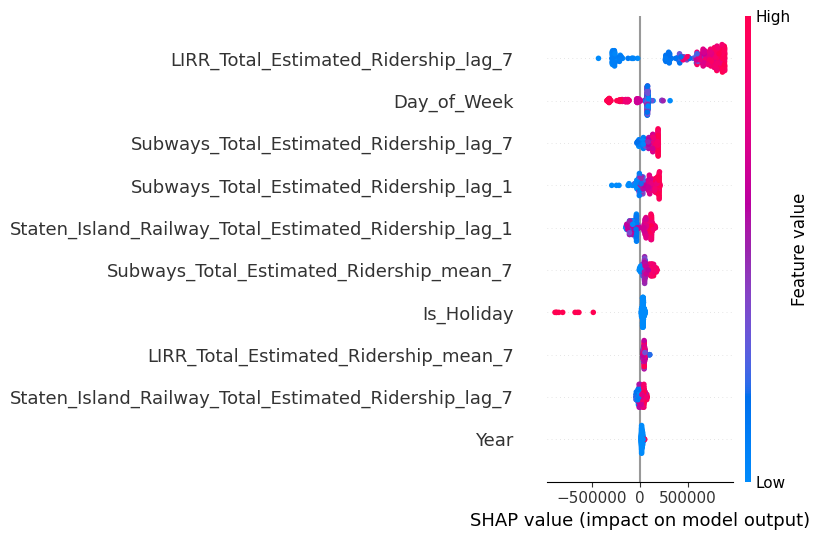

In [86]:
explainer = shap.TreeExplainer(GBM_models['Subways_Total_Estimated_Ridership'])
shap_values = explainer.shap_values(X_test)

plt.figure(figsize=(8, 6))  # Set smaller figure size (width, height in inches)
shap.summary_plot(shap_values, X_test, show=False, max_display=10)
plt.show()

#### MTA Bus SHAP

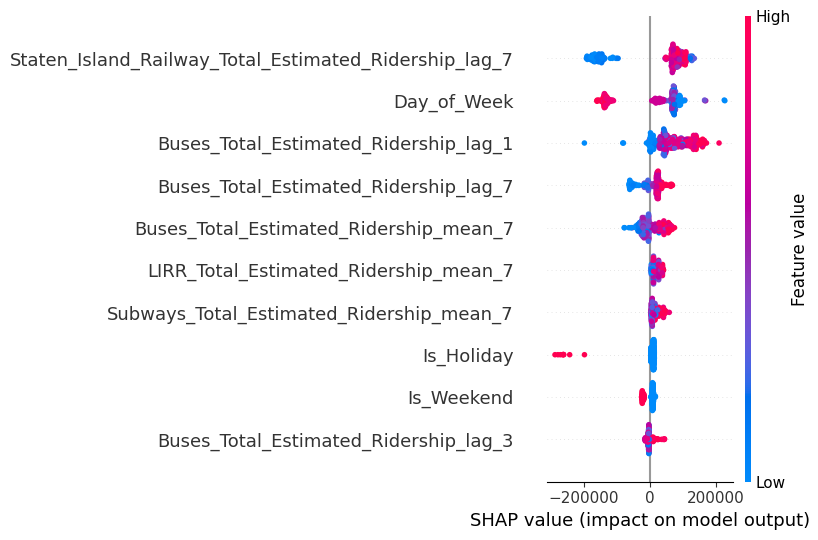

In [87]:
explainer = shap.TreeExplainer(GBM_models['Buses_Total_Estimated_Ridership'])
shap_values = explainer.shap_values(X_test)

plt.figure(figsize=(8, 6))  # Set smaller figure size (width, height in inches)
shap.summary_plot(shap_values, X_test, show=False, max_display=10)
plt.show()

We see that `Staten_Island_railway_Total_Ridership_lag_7` has a very high SHAP value for Total Buse ridership, which is likely correlation noise.   
We will need to confirm if this is the case

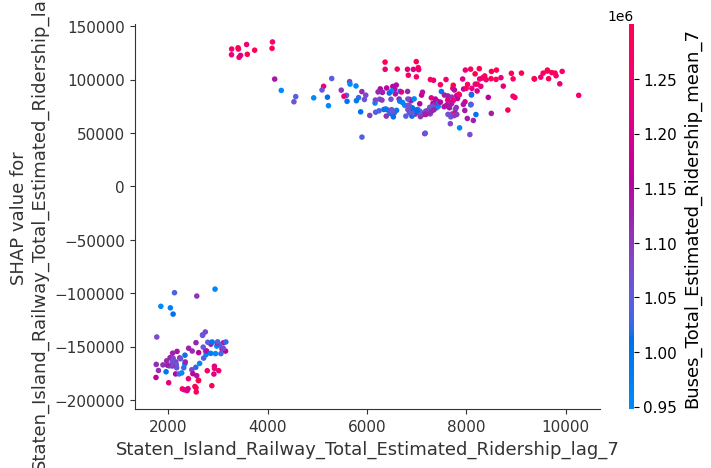

In [96]:
shap.dependence_plot(
    'Staten_Island_Railway_Total_Estimated_Ridership_lag_7',
    shap_values,
    X_test,
)

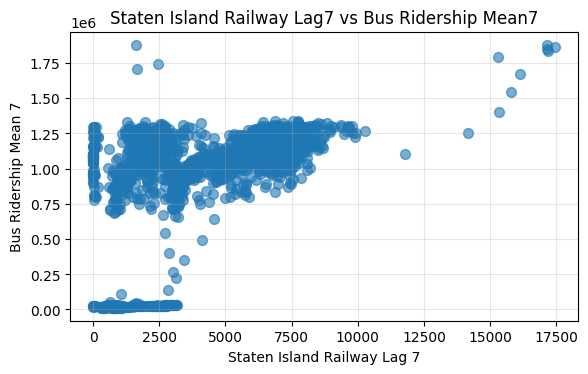

In [99]:
# Scatter plot of Staten Island Railway Lag7 vs Bus Ridership Mean7
plt.figure(figsize=(6, 4))
plt.scatter(df['Staten_Island_Railway_Total_Estimated_Ridership_lag_7'], 
           df['Buses_Total_Estimated_Ridership_mean_7'], 
           alpha=0.6, s=50)
plt.xlabel('Staten Island Railway Lag 7')
plt.ylabel('Bus Ridership Mean 7')
plt.title('Staten Island Railway Lag7 vs Bus Ridership Mean7')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


We can see that it is very likely a spurious correlation.

#### Long Island Railroad SHAP

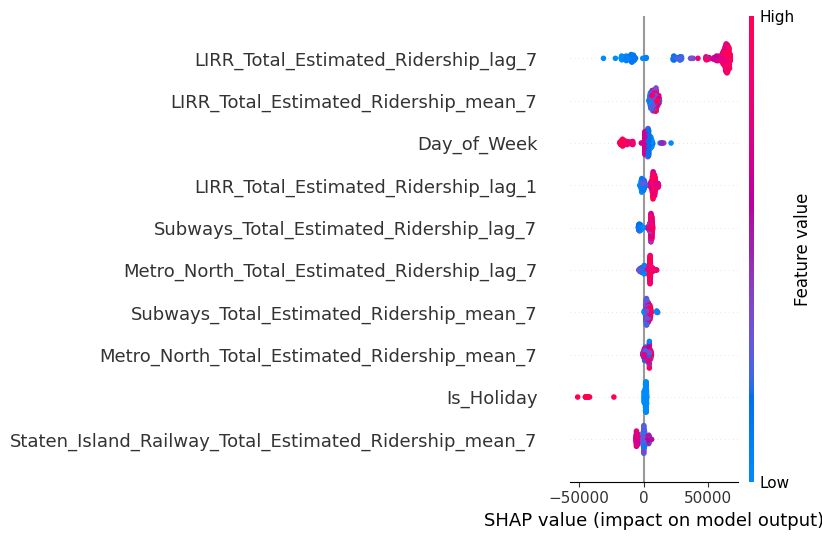

In [100]:
explainer = shap.TreeExplainer(GBM_models['LIRR_Total_Estimated_Ridership'])
shap_values = explainer.shap_values(X_test)

plt.figure(figsize=(8, 6))  # Set smaller figure size (width, height in inches)
shap.summary_plot(shap_values, X_test, show=False, max_display=10)
plt.show()

#### Metro-North SHAP

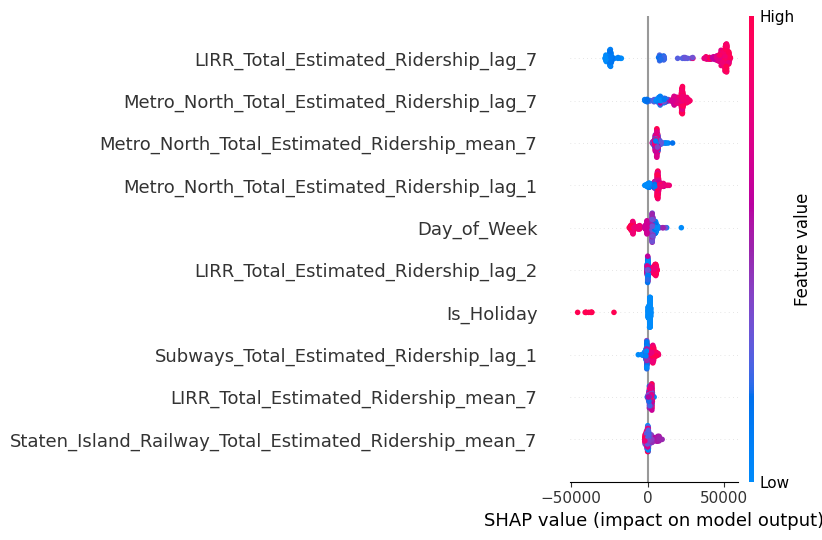

In [101]:
explainer = shap.TreeExplainer(GBM_models['Metro_North_Total_Estimated_Ridership'])
shap_values = explainer.shap_values(X_test)

plt.figure(figsize=(8, 6))  # Set smaller figure size (width, height in inches)
shap.summary_plot(shap_values, X_test, show=False, max_display=10)
plt.show()

#### Staten Island Railway SHAP

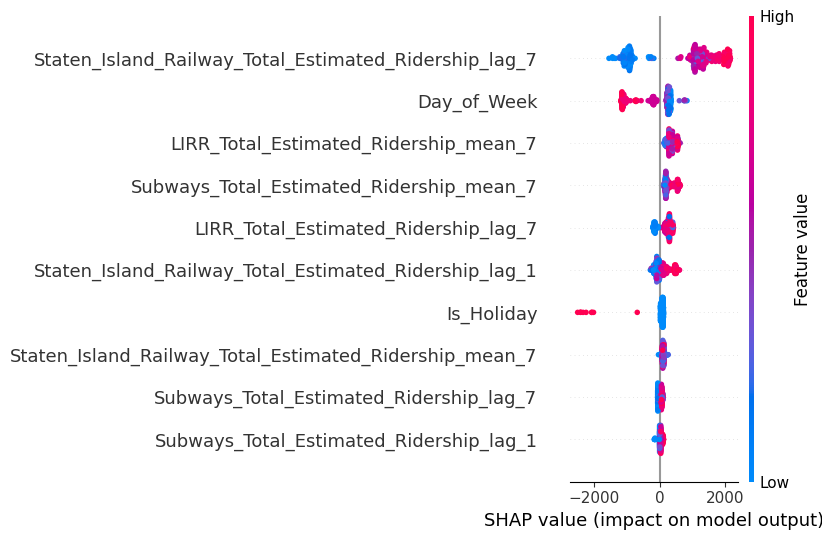

In [102]:
explainer = shap.TreeExplainer(GBM_models['Staten_Island_Railway_Total_Estimated_Ridership'])
shap_values = explainer.shap_values(X_test)

plt.figure(figsize=(8, 6))  # Set smaller figure size (width, height in inches)
shap.summary_plot(shap_values, X_test, show=False, max_display=10)
plt.show()

# 5. Removing Extra Features and Retraining